In [1]:
import numpy as np
import scipy.io as sio
from sklearn.utils import shuffle
import pathlib
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import h5py
import zipfile

%matplotlib inline
# %load_ext autoreload
# %autoreload 2

Prepare the notebook by downloading the milling data file and other important files. This needs to be done if running in google colab. If the repository has been cloned from github, then there is no need.

In [2]:
cwd = Path.cwd() # current working directory

folder_raw_data = Path('data/raw/') # raw data folder that holds the .zip .mat files for milling data
folder_processed_data = Path('data/processed') # processed data folder

In [3]:
# if the the raw data folder does not exist, then you are likely
# in a google colab environment. In that case, we will create the 
# raw data and processed data folders and download the appropriate
# files
if folder_raw_data.exists() == False:

    pathlib.Path(folder_raw_data).mkdir(parents=True, exist_ok=True)
    os.chdir(folder_raw_data)
    !wget 'https://ti.arc.nasa.gov/m/project/prognostic-repository/mill.zip'
    
os.chdir(cwd) # change back to root directory

if folder_processed_data.exists() == False:

    pathlib.Path(folder_processed_data).mkdir(parents=True, exist_ok=True)
    os.chdir(folder_processed_data)
    !wget 'https://github.com/tvhahn/ml-tool-wear/blob/master/data/processed/labels_with_tool_class.csv'
    
os.chdir(cwd)

# extract mill.mat from the zip file
with zipfile.ZipFile(folder_raw_data / 'mill.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_raw_data)

# Data Exploration

Explore the matlab file first.

In [4]:
# load the data from the matlab file
m = sio.loadmat(folder_raw_data / 'mill.mat',struct_as_record=True)

# store the 'mill' data in a seperate np array
data = m['mill']

Get an idea of the stucture of the data array.

In [5]:
# show some of the info from the matlab file
print('Keys in the matlab dict file: \n', m.keys(), '\n')

# store the field names in the data np array in a tuple, l
l = data.dtype.names
print('List of the field names:\n',l)

Keys in the matlab dict file: 
 dict_keys(['__header__', '__version__', '__globals__', 'mill']) 

List of the field names:
 ('case', 'run', 'VB', 'time', 'DOC', 'feed', 'material', 'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle')


Store the label information in its own dataframe.

In [8]:
# store the field names in the data np array in a tuple, l
l = data.dtype.names

# create empty dataframe for the labels
df_labels = pd.DataFrame()

# get the labels from the original .mat file and put in dataframe
for i in range(7):
    # list for storing the label data for each field
    x = []
    
    # iterate through each of the unique cuts
    for j in range(167):
        x.append(data[0,j][i][0][0])
    x = np.array(x)
    df_labels[str(i)] = x

# add column names to the dataframe
df_labels.columns = l[0:7]
    
# create a column with the unique cut number
df_labels['cut_no'] = [i for i in range(167)]

df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no
0,1,1,0.00,2,1.5,0.5,1,0
1,1,2,NaN,4,1.5,0.5,1,1
2,1,3,NaN,6,1.5,0.5,1,2
3,1,4,0.11,7,1.5,0.5,1,3
4,1,5,NaN,11,1.5,0.5,1,4


Make a simple plot to look at some of the data.

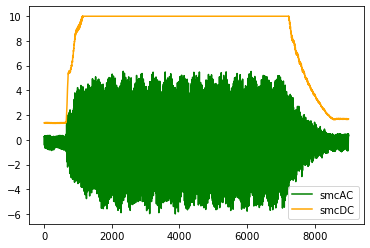

In [9]:
fig, ax = plt.subplots()

ax.plot(data[0,166]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,166]['smcDC'],color='orange',label='smcDC')

plt.legend()

If you look at all the cuts, you'll find that cuts 18 and 95 (index 17 and 94) are off -- they should be discarded.

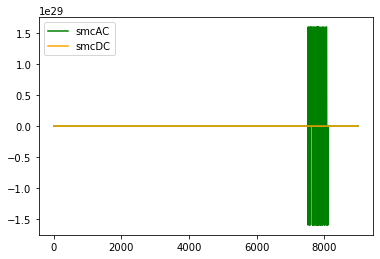

In [10]:
fig, ax = plt.subplots()

ax.plot(data[0,17]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,17]['smcDC'],color='orange',label='smcDC')

plt.legend()

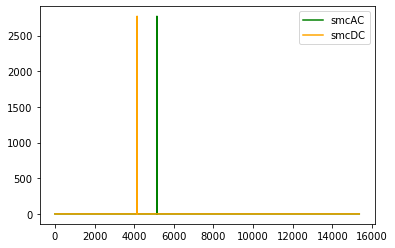

In [11]:
fig, ax = plt.subplots()

ax.plot(data[0,94]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,94]['smcDC'],color='orange',label='smcDC')

plt.legend()

Cut 106 is also weird...

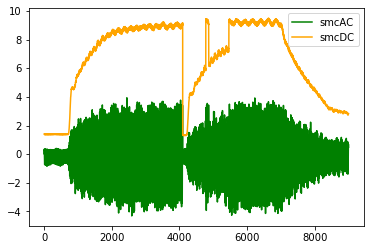

In [12]:
fig, ax = plt.subplots()

ax.plot(data[0,105]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,105]['smcDC'],color='orange',label='smcDC')

plt.legend()

We'lll create a pretty plot of all the six signals for a certain cut.

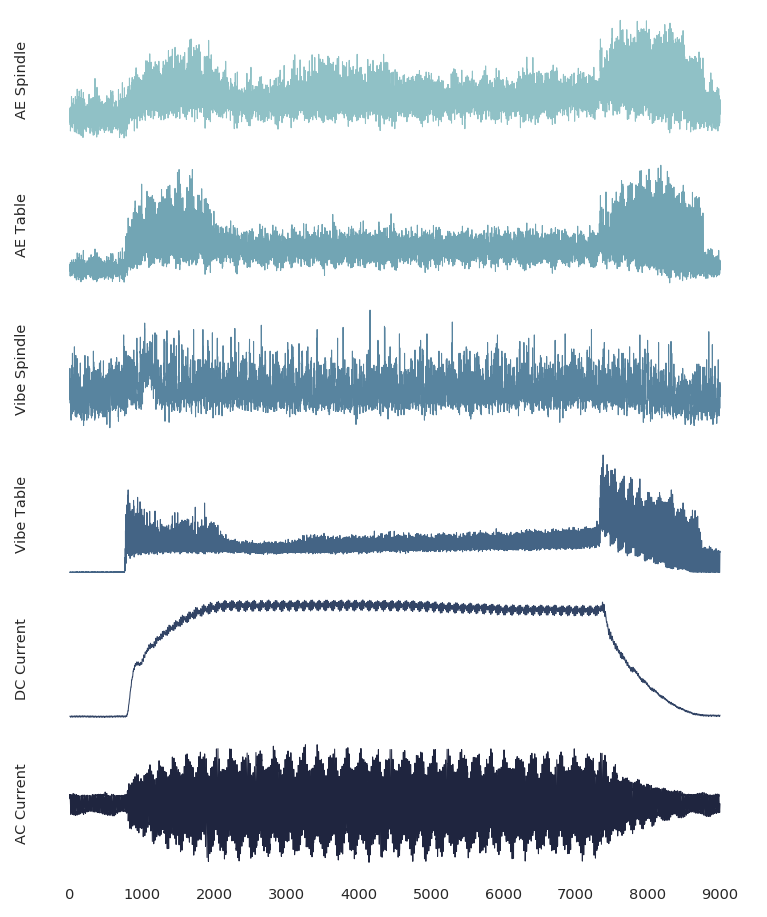

In [13]:
def plot_cut(cut_signal, signals_trend, cut_no):

    # define colour palette and seaborn style
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)
    sns.set(style="white", context="notebook")

    fig, axes = plt.subplots(
        6, 1, dpi=150, figsize=(5, 6), sharex=True, constrained_layout=True,
    )

    # the "revised" signal names so it looks good on the chart
    signal_names_revised = [
        "AE Spindle",
        "AE Table",
        "Vibe Spindle",
        "Vibe Table",
        "DC Current",
        "AC Current",
    ]

    # go through each of the signals
    for i in range(6):
        # plot the signals
        axes[i].plot(cut_signal[signals_trend[i]], color=pal[i], linewidth=0.5, alpha=1)
        axis_label = signal_names_revised[i]
        axes[i].set_ylabel(
            axis_label, fontsize=7,
        )

        # if it's not the last signal...
        if i != 5:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_xticks(
                [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
            )
            axes[i].set_yticks([])

        else:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([])
            axes[i].tick_params(axis="x", labelsize=7)


signals_trend = list(l[7:])  # there are 6 types of signals, smcAC to AE_spindle
signals_trend = signals_trend[
    ::-1
]  # reverse the signal order so that it is matching other charts
cut_signal = data[0, 145]

plot_cut(cut_signal, signals_trend, "cut_145")
plt.show()


# Data Prep

We'll create the X and y data sets and split them into their respective training/validation/testing sets. We'll save the data in hdf5 files.

In [14]:
from sklearn.model_selection import train_test_split
import data_prep

Helper functions for the data prep. Most of the data prep is done by the DataPrep class (from data_prep.py).

In [19]:
# simple functions used in the data prep

# Scaler Function
def scaler(x, min_val_array, max_val_array):

    # get the shape of the array
    s, _, sub_s = np.shape(x)

    for i in range(s):
        for j in range(sub_s):
            x[i, :, j] = np.divide(
                (x[i, :, j] - min_val_array[j]),
                np.abs(max_val_array[j] - min_val_array[j]),
            )

    return x


# min-max function
def get_min_max(x):

    # flatten the input array http://bit.ly/2MQuXZd
    flat_vector = np.concatenate(x)

    min_vals = np.min(flat_vector, axis=0)
    max_vals = np.max(flat_vector, axis=0)

    return min_vals, max_vals

In [33]:
data_file = folder_raw_data / "mill.mat"

prep = data_prep.DataPrep(data_file)

# load the labeled CSV (NaNs filled in by hand)
df_labels = pd.read_csv(
    folder_processed_data / 'labels_with_tool_class.csv'
)


# discard certain cuts as they are strange
cuts_remove = [17, 94]
df_labels.drop(cuts_remove, inplace=True)

# prepare the entire X and y data sets
X, y, dfy = prep.return_xy(
    df_labels, prep.data, prep.field_names[7:], window_size=64, stride=64, track_y=True
)

X_train, X_test, dfy_train, dfy_test = train_test_split(
    X, dfy, test_size=0.33, random_state=15, stratify=dfy["class"]
)

X_val, X_test, dfy_val, dfy_test = train_test_split(
    X_test, dfy_test, test_size=0.50, random_state=10, stratify=dfy_test["class"]
)

# turn y dataframes into numpy arrays
y_train = dfy_train["class"].to_numpy(dtype="int")
y_val = dfy_val["class"].to_numpy(dtype="int")
y_test = dfy_test["class"].to_numpy(dtype="int")


# get the minimum and maximum values from the training data set X_train
min_vals, max_vals = get_min_max(X_train)

# scale the data sets
X = scaler(X, min_vals, max_vals)
X_train = scaler(X_train, min_vals, max_vals)
X_val = scaler(X_val, min_vals, max_vals)
X_test = scaler(X_test, min_vals, max_vals)

print('Min/max values from X_train:')
print(min_vals)

print("\nShape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("\nShape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("\nShape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# slim down the X_train and X_val
X_train_slim, y_train_slim = prep.remove_classes([1, 2], y_train, X_train)

print("\nShape of X_train_slim:", X_train_slim.shape)
print("Shape of y_train_slim:", y_train_slim.shape)

X_val_slim, y_val_slim = prep.remove_classes([1, 2], y_val, X_val)

print("\nShape of X_val_slim:", X_val_slim.shape)
print("Shape of y_val_slim:", y_val_slim.shape)

Min/max values from X_train:
[-6.96777344  3.41796875  0.20263672  0.21850586  0.01464844  0.09094238]

Shape of X_train: (7751, 64, 6)
Shape of y_train: (7751,)

Shape of X_val: (1909, 64, 6)
Shape of y_val: (1909,)

Shape of X_test: (1910, 64, 6)
Shape of y_test: (1910,)

Shape of X_train_slim: (2831, 64, 6)
Shape of y_train_slim: (2831,)

Shape of X_val_slim: (697, 64, 6)
Shape of y_val_slim: (697,)


Save the data splits in the processed data folder (also save the "slimmed" down versions of the X_train and X_val).

In [34]:
# X_train, y_train
with h5py.File("data/processed/X_train.hdf5", "w") as f:
    dset = f.create_dataset("X_train", data=X_train)
with h5py.File("data/processed/y_train.hdf5", "w") as f:
    dset = f.create_dataset("y_train", data=y_train)

# X_val, y_val
with h5py.File("data/processed/X_val.hdf5", "w") as f:
    dset = f.create_dataset("X_val", data=X_val)
with h5py.File("data/processed/y_val.hdf5", "w") as f:
    dset = f.create_dataset("y_val", data=y_val)

# X_test, y_test
X_test = scaler(X_test, min_vals, max_vals)
with h5py.File("data/processed/X_test.hdf5", "w") as f:
    dset = f.create_dataset("X_test", data=X_test)
with h5py.File("data/processed/y_test.hdf5", "w") as f:
    dset = f.create_dataset("y_test", data=y_test)

# X_train_slim = scaler(X_train_slim, min_vals, max_vals)
with h5py.File("data/processed/X_train_slim.hdf5", "w") as f:
    dset = f.create_dataset("X_train_slim", data=X_train_slim)
with h5py.File("data/processed/y_train_slim.hdf5", "w") as f:
    dset = f.create_dataset("y_train_slim", data=y_train_slim)

# X_val_slim = scaler(X_val_slim, min_vals, max_vals)
with h5py.File("data/processed/X_val_slim.hdf5", "w") as f:
    dset = f.create_dataset("X_val_slim", data=X_val_slim)
with h5py.File("data/processed/y_val_slim.hdf5", "w") as f:
    dset = f.create_dataset("y_val_slim", data=y_val_slim)

No handles with labels found to put in legend.


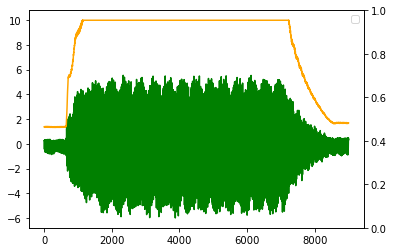

In [10]:
# plot some of the data
fig, ax1 = plt.subplots()

# Stackoverflow on how to make legend for primary and secondary axis together: https://bit.ly/2yJ20op
ax2 = ax1.twinx()
p1 = ax1.plot(data[0,166]['smcAC'],'g-',label='smcAC')
p2 = ax1.plot(data[0,166]['smcDC'],color='orange',label='smcDC')

plt.legend()

# # Position legend. https://bit.ly/2yJ20op
# p = p1+p2
# labs = [l.get_label() for l in p]
# ax1.legend(p, labs, loc="upper right",)

In [ ]:
current_dir = Path.cwd()
processed_data = current_dir.parent.parent / 'src' 
processed_data

In [ ]:
(X_train, y_train, 
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = data_transforms.load_train_test(processed_data) 

In [ ]:
X_train.shape

In [ ]:
plt.plot(X_train[0])

In [ ]:
test_signal = X_train[0,:,0]
plt.plot(test_signal)

In [ ]:
# s, _, sub_s = np.shape(X_train)
# print(np.shape(X_train))
# print(s,sub_s)

# for i in range(s):
#     for j in range(sub_s):
#         X_train[i,:,j] = np.interp(X_train[i,:,j], (min_vals[j], max_vals[j]), (0, 1))

In [ ]:
def scaler(x, min_val_array, max_val_array, lower_norm_val, upper_norm_val):
    
    # get the shape of the array
    s, _, sub_s = np.shape(x)
    
    for i in range(s):
        for j in range(sub_s):
            x[i,:,j] = np.interp(x[i,:,j], 
                                 (min_val_array[j], max_val_array[j]), 
                                 (lower_norm_val, upper_norm_val))
            
    return x
    
def get_min_max(x):

    # flatten the input array http://bit.ly/2MQuXZd
    flat_vector = np.concatenate(x)

    min_vals = np.min(flat_vector,axis=0)
    max_vals = np.max(flat_vector,axis=0)

    return min_vals, max_vals


In [ ]:
min_vals, max_vals = get_min_max(X_train)
print(min_vals)
print(max_vals)

X_sample = X_train[0:2]
X_sample = scaler(X_sample, min_vals, max_vals, 0, 1)


In [ ]:
plt.plot(X_sample[0])

In [ ]:
plt.plot(X_train[0])

However, there is a problem when the signal is out of the lower/upper scaling range:

In [ ]:
X_val = scaler(X_val, min_vals, max_vals, 0, 0.6)
min_vals_validation, max_vals_validation = get_min_max(X_val)
print(min_vals_validation)
print(max_vals_validation)

X_sample = scaler(X_val, min_vals, max_vals, 0, 1)
plt.plot(X_sample[0])

## Make scaler that doesn't truncate

In [ ]:
(X_train, y_train, 
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = data_transforms.load_train_test(processed_data) 

In [ ]:
def scaler(x, min_val_array, max_val_array):
    
    # get the shape of the array
    s, _, sub_s = np.shape(x)
    
    for i in range(s):
        for j in range(sub_s):
            x[i,:,j] = np.divide((x[i,:,j] - min_val_array[j]), np.abs(max_val_array[j] - min_val_array[j]))
           
    return x
    

In [ ]:
min_vals, max_vals = get_min_max(X_train)
print(min_vals)
print(max_vals)

X_sample = X_train
X_sample = scaler(X_sample, min_vals, max_vals)

In [ ]:
min_vals, max_vals = get_min_max(X_sample)
print(min_vals)
print(max_vals)

In [ ]:
X_sample = X_train[0,:,0]
plt.plot(X_sample)

In [ ]:
X_val = scaler(X_test, min_vals, max_vals)

min_vals_validation, max_vals_validation = get_min_max(X_val)
print(min_vals_validation)
print(max_vals_validation)

# Make train/val/test set lists

In [ ]:
df_labels = pd.read_csv('labels_with_tool_class.csv',index_col=False)
df_labels.head()

In [ ]:
cut_numbers = np.arange(0,167)
cut_numbers

In [ ]:
# delete certain cut_numbers that we know are erroneous
# cut_no to delete
cuts_to_delete = np.array([17, 94])

y = df_labels['tool_class'].to_numpy()
y = np.delete(y,cuts_to_delete)
print(y.shape)
X = np.delete(cut_numbers,cuts_to_delete)
print(X.shape)
X

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=15, stratify=y)

print(cut_no_test.shape, y_test.shape)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, 
                                                random_state=42, 
                                                stratify=y_test)

In [ ]:
cuts_with_failure = [60,70,93,114,140,141,142,143,144,152,153,160]

print('X_train cuts with failures:')
for i in X_train:
    if i in cuts_with_failure:
        print(i)

print('X_val cuts with failures:')
for i in X_val:
    if i in cuts_with_failure:
        print(i)
        
print('X_test cuts with failures:')
for i in X_test:
    if i in cuts_with_failure:
        print(i)